# ADVANTAGES OF PORTABLE-ALPHA STRUCTURES

## `import`s

In [17]:
from __future__ import annotations

from typing import Final

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

import foggy_statslib.core as fc

## What is portable alpha?

Say our universe consists of three stocks, A, B, and C, with A twice as large and half as volatile as B or C. Don't worry about the math setup in this part, the details are not important. But I've copy-pasted a bunch of utility functions that are more fleshed-out [here](https://github.com/sparshsah/foggy-statslib/blob/main/foggy_statslib/fin.py) so that interested readers can play with the numbers.

In [44]:
MKT_CAP: Final[pd.Series] = pd.Series({"A": 1_000, "B": 500, "C": 500})
BMK: Final[pd.Series] = MKT_CAP / MKT_CAP.sum()
VOL: Final[pd.Series] = pd.Series({"A": 0.10, "B": 0.20, "C": 0.20})
CORR: Finall[pd.DataFrame] = pd.DataFrame(
    {
        "A": {"A": 1, "B": 0.50, "C": 0.50},
        "B": {"A": 0.50, "B": 1, "C": 0.90},
        "C": {"A": 0.50, "B": 0.90, "C": 1},
    }
)
COV: Final[pd.DataFrame] = (
    pd.DataFrame(np.diag(VOL), index=VOL.index, columns=VOL.index)
    @ CORR
    @ pd.DataFrame(np.diag(VOL), index=VOL.index, columns=VOL.index)
)

def _get_pflio_cov(w_a: pd.Series, w_b: pd.Series = BMK) -> float:
    return w_a @ COV @ w_b

def _get_pflio_vol(w: pd.Series = BMK) -> float:
    return _get_pflio_cov(w, w)**0.5

def _get_pflio_corr(w_a: pd.Series, w_b: pd.Series = BMK) -> float:
    cov = _get_pflio_cov(w_a=w_a, w_b=w_b)
    vol_a = _get_pflio_vol(w=w_a)
    vol_b = _get_pflio_vol(w=w_b)
    return cov / (vol_a * vol_b)

def _get_pflio_beta(w_of: pd.Series, w_on: pd.Series = BMK) -> float:
    corr = _get_pflio_corr(w_of, w_on)
    vol_of = _get_pflio_vol(w_of)
    vol_on = _get_pflio_vol(w_on)
    return corr * (vol_of / vol_on)

def _get_beta_part(w_of: pd.Series, w_on: pd.Series = BMK) -> float:
    beta = _get_pflio_beta(w_of=w_of, w_on=w_on)
    return beta * w_on

def _get_alpha_part(w_of: pd.Series, w_on: pd.Series = BMK) -> float:
    hedge = _get_beta_part(w_of=w_of, w_on=w_on)
    return w_of - hedge

def _decompose(w_of: pd.Series, w_on: pd.Series = BMK) -> float:
    d = pd.DataFrame(
        {
            "beta_part": _get_beta_part(w_of=w_of, w_on=w_on),
            "alpha_part": _get_alpha_part(w_of=w_of, w_on=w_on),
        }
    )
    d.loc[:, "sum"] = d.sum(axis="columns")
    return d

Think of two funds investing in this market:
* An index-tracking mutual fund, and
* A traditional long-only stock-picking hedge fund (I already cringe at this name... how can you be long-only and also hedged... the whole point of a hedge fund used to be uncorrelated absolute returns...).

They might have holdings something like this:

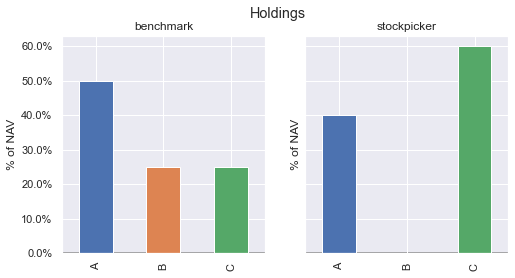

In [88]:
ww = pd.DataFrame(
    {
        "benchmark": BMK,
        "stockpicker": {"A": 0.40, "B": 0, "C": 0.60},
    }
)

_, ax = plt.subplots(ncols=len(ww.columns), sharex=True, sharey=True)
for (i, (f, w)) in enumerate(ww.items()):
    fc.plot(
        w,
        kind="bar",
        color=sns.color_palette(),
        ypct=True,
        ylabel="% of NAV",
        title=f,
        ax=ax[i],
        figsize=(4*len(ax), 4),
    )
plt.suptitle("Holdings")
plt.show()

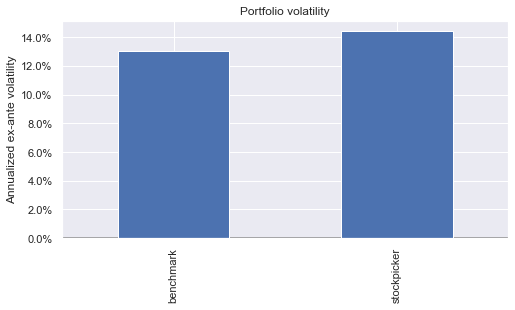

<AxesSubplot:title={'center':'Portfolio volatility'}, ylabel='Annualized ex-ante volatility'>

In [89]:
fc.plot(
    pd.Series(
        {
            f: _get_pflio_vol(w)
            for (f, w) in ww.items()
        }
    ),
    kind="bar",
    ypct=True,
    ylabel="Annualized ex-ante volatility",
    title="Portfolio volatility",
    figsize=(8, 4),
)

Now, let's decompose the stockpicker's holdings into two "parts":
* A long-only beta part, and
* An market-neutral long-short alpha part.

The two parts will sum together to exactly replicate the stockpicker's holdings.

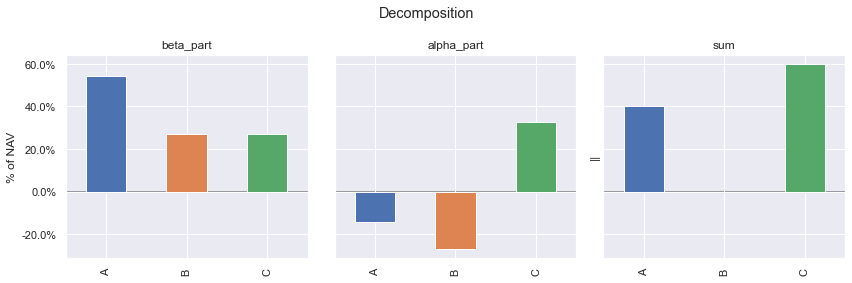

In [91]:
d = _decompose(ww["stockpicker"])
fig, ax = plt.subplots(ncols=len(d.columns), sharex=True, sharey=True)
for (i, (f, w)) in enumerate(d.items()):
    fc.plot(
        w,
        kind="bar",
        color=sns.color_palette(),
        ypct=True,
        # idk the why the middle plot's label gets hidden...
        ylabel={
            "beta_part": "% of NAV",
            "alpha_part": "+",
            "sum": "||",
        }[f],
        title=f,
        ax=ax[i],
        figsize=(4*len(ax), 4),
    )
plt.suptitle("Decomposition")
fig.tight_layout()
plt.show()

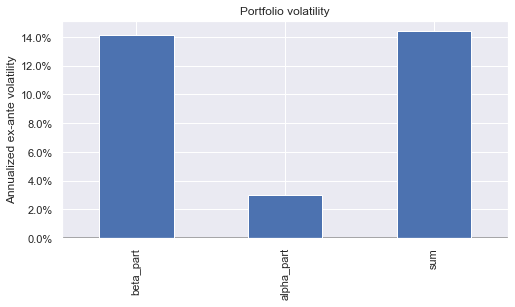

<AxesSubplot:title={'center':'Portfolio volatility'}, ylabel='Annualized ex-ante volatility'>

In [81]:
fc.plot(
    pd.Series(
        {
            f: _get_pflio_vol(w)
            for (f, w) in d.items()
        }
    ),
    kind="bar",
    ypct=True,
    ylabel="Annualized ex-ante volatility",
    title="Portfolio volatility",
    figsize=(8, 4),
)

Portable alpha is the idea that you should actually explicitly invest in two separate funds (even if managed by the same manager) according to the decomposition. Furthermore, the beta part should be a simple long-only investment into the index-tracking mutual fund.

## Why portable alpha?

### Tax benefits

Suppose next month your stockpicker's views change, and her new portfolio looks like this:

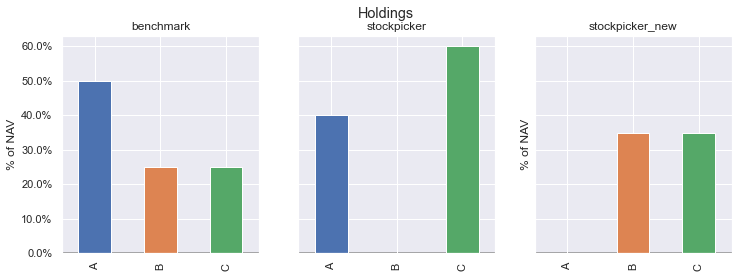

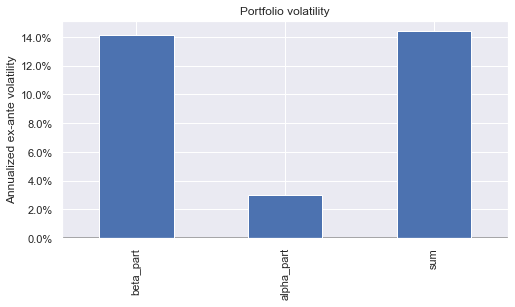

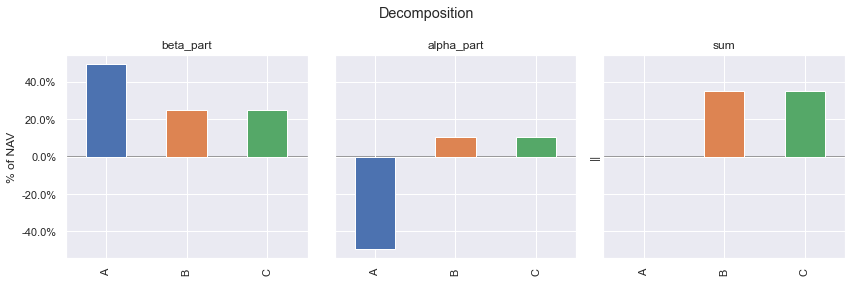

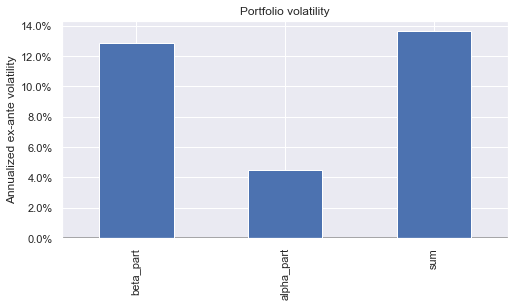

<AxesSubplot:title={'center':'Portfolio volatility'}, ylabel='Annualized ex-ante volatility'>

In [92]:
ww.loc[:, "stockpicker_new"] = pd.Series({"A": 0, "B": 0.35, "C": 0.35})
_, ax = plt.subplots(ncols=len(ww.columns), sharex=True, sharey=True)
for (i, (f, w)) in enumerate(ww.items()):
    fc.plot(
        w,
        kind="bar",
        color=sns.color_palette(),
        ypct=True,
        ylabel="% of NAV",
        title=f,
        ax=ax[i],
        figsize=(4*len(ax), 4),
    )
plt.suptitle("Holdings")
plt.show()
fc.plot(
    pd.Series(
        {
            f: _get_pflio_vol(w)
            for (f, w) in d.items()
        }
    ),
    kind="bar",
    ypct=True,
    ylabel="Annualized ex-ante volatility",
    title="Portfolio volatility",
    figsize=(8, 4),
)

d_new = _decompose(ww["stockpicker_new"])
fig, ax = plt.subplots(ncols=len(d_new.columns), sharex=True, sharey=True)
for (i, (f, w)) in enumerate(d_new.items()):
    fc.plot(
        w,
        kind="bar",
        color=sns.color_palette(),
        ypct=True,
        # idk the why the middle plot's label gets hidden...
        ylabel={
            "beta_part": "% of NAV",
            "alpha_part": "+",
            "sum": "||",
        }[f],
        title=f,
        ax=ax[i],
        figsize=(4*len(ax), 4),
    )
plt.suptitle("Decomposition")
fig.tight_layout()
plt.show()
fc.plot(
    pd.Series(
        {
            f: _get_pflio_vol(w)
            for (f, w) in d.items()
        }
    ),
    kind="bar",
    ypct=True,
    ylabel="Annualized ex-ante volatility",
    title="Portfolio volatility",
    figsize=(8, 4),
)

### Fair fees

Look at the portfolio volatilities. The "beta part" has annualized ex-ante vol of about 14%, whereas the alpha part has annualized ex-ante vol (AKA "tracking error") of only 3%. Together, the two have vol just over 14% (power of diversification!).

So most of the stockpicker's risk is just the beta part, which you could easily get by putting your money into a buy-and-hold passive index-tracking mutual fund or ETF! Why pay 2+20 for this?

Instead, get the beta part basically for free from some large institutional index-tracking mutual fund, and go back to your alpha manager and say "you're running just 3% of active risk for me, I'm fine paying you 20% performance fee but no way in hell I'm going to let you eat 2% management fee every year".